In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json

d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework

In [4]:
normal_data = np.load("../data/WADI/normal2.0.npy")
anomaly_data = np.load("../data/WADI/anomaly2.0.npy")

In [5]:
anomaly_data_2 = anomaly_data.copy()
delay_time = 300
for i in range(len(anomaly_data_2)-delay_time):
    if(anomaly_data_2[i][-1]>0.9 and anomaly_data_2[i+1][-1]<0.1):
        for j in range(delay_time):
               anomaly_data_2[i+1+j][-1]=1

In [6]:
pc_dim=30

In [7]:
pca = PCA(n_components = pc_dim)
pca.fit(normal_data)
print(pca.explained_variance_ratio_, "sum: ", sum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.30144549 0.15225657 0.09834537 0.08305277 0.06051555 0.03886386
 0.03163355 0.0236635  0.01974645 0.01766029 0.01625351 0.01562417
 0.01305819 0.01177981 0.00954697 0.00881075 0.0083146  0.00801534
 0.00677399 0.00577439 0.00533859 0.00474169 0.00435409 0.00433019
 0.00368856 0.00335285 0.00325704 0.00302169 0.00284495 0.00263818] sum:  0.968702934308402
[1197.19689593  850.84255411  683.81424195  628.40298036  536.40729374
  429.8670569   387.82441759  335.42905755  306.41196177  289.77443449
  277.99359888  272.55845769  249.17399417  236.66298629  213.05607189
  204.67628196  198.83003171  195.21902226  179.46659143  165.69686784
  159.3216034   150.1508007   143.88307322  143.48769178  132.43099007
  126.26073692  124.44367281  119.8631954   116.30496295  111.99870319]


In [8]:
normal_pc = pca.transform(normal_data)

In [17]:
anomaly_pc = np.zeros((len(anomaly_data_2), pc_dim+1))
anomaly_pc[:, :-1]= pca.transform(anomaly_data_2[:,:-1])
anomaly_pc[:,-1]=anomaly_data_2[:,-1]

In [18]:
np.save("../data/WADI/normal_pc3.0.npy", normal_pc)
np.save("../data/WADI/anomaly_pc3.0.npy", anomaly_pc)

In [19]:
normal_pc = np.load("../data/WADI/normal_pc3.0.npy")
anomaly_pc = np.load("../data/WADI/anomaly_pc3.0.npy")

In [20]:
def interp_1darray(data):
    assert len(data.shape)==1, "data is not 1d"
    num_index = [i for i in range(len(data)) if not np.isnan(data[i])]
    f= interpolate.interp1d(num_index, data[num_index])
    data_new = f(range(len(data)))
    return data_new
    
def interp_2darray(data):
    assert len(data.shape)==2," data is not 2d "
    new_data = data.copy().T
    for i in range(len(new_data)):
        if(np.sum(np.isnan(new_data[i]))>0):
            new_data[i] = interp_1darray(new_data[i])
    new_data = new_data.T
    return new_data
    
def normalize_1d(data):
    new_data = data.copy()
    min_ = min(new_data)
    max_ = max(new_data)
    if(max_-min_==0):
        new_data = np.ones(new_data.shape,dtype="double") 
    #print(data)
    else:
        new_data= (new_data-min_)/(max_-min_)
    #print(data)
    return new_data

def normalize_2d(data, axis = 1):
    new_data = data.copy()
    if(axis == 0):
        new_data = new_data.T
    #print(data.shape)
    for i in range(len(new_data)):
        new_data[i] = normalize_1d(new_data[i])
    if(axis == 0):
        new_data = new_data.T
        
    return new_data

In [21]:
normal_len = len(normal_pc)
anomaly_len = len(anomaly_pc)
dimension = normal_pc.shape[1]
sample_size = 30
train_size = (normal_len-sample_size)//10+1
sample_step = np.floor((normal_len-sample_size)/(train_size-1)).astype(int)
print("sample_step: ", sample_step)
train_x = np.zeros((train_size, sample_size, dimension), dtype="double")
for i in range(train_size):
    train_x[i, :, :] = normal_pc\
    [i*sample_step: (i*sample_step+sample_size), :]
train_y = np.zeros((train_size, sample_size*dimension), dtype = "double")
for i in range(train_size):
    train_y[i] = train_x[i,:,:].ravel()
test_size = (anomaly_len-sample_size)//1+1
test_sample_step=np.floor((anomaly_len-sample_size)/(test_size-1)).astype(int)
print("test_sample_step: ", test_sample_step)
test_index = np.array([i*test_sample_step for i in range(test_size)])
test_normal_index = np.array([i for i in test_index \
                              if np.mean(anomaly_pc[i:(i+sample_size), -1])<0.2])
print("normal size:", len(test_normal_index))
left_index_index = np.array(range(0,len(test_normal_index),1))
print("left size: ", len(left_index_index))

test_normal_index_left = test_normal_index[left_index_index]
test_index_final = np.array([i for i in test_index \
                             if (i not in test_normal_index) or (i in test_normal_index_left)])
print("final: ", len(test_index_final))
new_test_size = len(test_index_final)
print(new_test_size)
test_x = np.zeros((new_test_size, sample_size, dimension), dtype = "double")
for i in range(new_test_size):
    test_x[i,:,:] = anomaly_pc[test_index_final[i]:(test_index_final[i]+sample_size), :-1]
test_y = np.zeros((new_test_size, sample_size*dimension), dtype = "double")
for i in range(new_test_size):
    test_y[i] = test_x[i,:,:].ravel()
test_attack_level = np.array([np.mean(anomaly_pc\
                                      [i:(i+sample_size), -1]) for i in test_index_final])
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    if(TP==0 or FP==0 or FN==0):
        #print("someone=0, TP=", TP, " FP=", FP, ", FN=",FN)
        return (0,0,0)
    pre = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    
def get_pred_errors(model, test_x, test_y):
    test_pred = model.predict(test_x)
    return np.array([mean_squared_error(test_y[i], test_pred[i]) for i in range(len(test_y))])
def eval_model(errors, attack_levels, th_int=0.1, attack_th=0.3):
    err_normalized = normalize_1d(errors)
    thresholds = np.arange(0.5*th_int,1,th_int)
    print("corr: ", np.corrcoef(err_normalized, attack_levels))
    attack_th = np.array([1 if i>attack_th else 0 for i in attack_levels])
    
    normal_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==0])
    anomaly_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==1])
    print("normal_err: ", pd.Series(normal_err).describe())
    print("anomaly_err:", pd.Series(anomaly_err).describe())
    
    
    res = {"th":np.zeros((len(thresholds))),"pre":np.zeros((len(thresholds))), "rec":np.zeros((len(thresholds))), "F1":np.zeros((len(thresholds)))}
    for i in range(len(thresholds)):
        th = thresholds[i]
        #print("Threshold = ", th)
        err_thd = np.array([1 if i >th else 0 for i in err_normalized])
        pre, rec, F1=get_eval(attack_th, err_thd)
        res["th"][i]=th
        res["pre"][i]=pre
        res["rec"][i] = rec
        res["F1"][i] = F1
    plt.subplot(1,3,1)
    plt.plot(thresholds, res["pre"])
    plt.xlabel("threshold")
    plt.ylabel("pre")
    plt.title("pre")
    
    plt.subplot(1,3,2)
    plt.plot(thresholds, res["rec"])
    plt.xlabel("threshold")
    plt.ylabel("rec")
    plt.title("rec")
    
    plt.subplot(1,3,3)
    plt.plot(thresholds, res["F1"])
    plt.xlabel("threshold")
    plt.ylabel("F1")
    plt.title("F1")
    return res

sample_step:  10
test_sample_step:  1
normal size: 5232
left size:  5232
final:  172772
172772


data_dim: 900
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10000/10000 [==============================] - 5s 522us/sample - loss: 0.1283 - mean_squared_error: 0.1283 - loss: 0.1287 - mean_squar - ETA: 0s - loss: 0.1286 - mean_squared
Epoch 2/5
10000/10000 [==============================] - 5s 476us/sample - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 3/5
10000/10000 [==============================] - 5s 489us/sample - loss: 0.1277 - mean_squared_error: 0.1277 - loss: 0.1277 - mean_squared_error: 0.
Epoch 4/5
10000/10000 [==============================] - 5s 495us/sample - loss: 0.1277 - mean_squared_error: 0.1277 - loss: 0.1278 - mean_squar
Epoch 5/5
10000/10000 [==============================] - 5s 463us/sample - loss: 0.1277 - mean_squared_error: 0.1277
corr:  [[1.         0.29017877]
 [0.29017877 1.        ]]
normal_err:  count    9385.000000
mean        0.192989
std         0.122918
min        

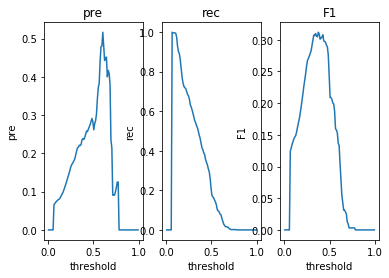

In [9]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)

res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01)
print(max(res["F1"])) 

In [13]:
model4.fit(train_x, train_y, epochs=5)

Epoch 1/5
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 2/5
10000/10000 [==============================] - 10s 988us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/5
10000/10000 [==============================] - 10s 970us/sample - loss: 0.1277 - mean_squared_error: 0.1277- loss:
Epoch 4/5
10000/10000 [==============================] - 10s 967us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 5/5
10000/10000 [==============================] - 10s 971us/sample - loss: 0.1277 - mean_squared_error: 0.1277


data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 7s 725us/sample - loss: 0.1283 - mean_squared_error: 0.1283
Epoch 2/5
10000/10000 [==============================] - 7s 677us/sample - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 3/5
10000/10000 [==============================] - 7s 694us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 4/5
10000/10000 [==============================] - 7s 702us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 5/5
10000/10000 [==============================] - 7s 690us/sample - loss: 0.1277 - mean_squared_error: 0.1277
corr:  [[1.         0.28997105]
 [0.28997105 1.        ]]
normal_err:  count    9368.000000
mean        0.192558
std         0.122382
min         0.000000
25%         0.112255
50%         0.162817
75%         0.236299
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.350023
std        0.164650
min        0.064861
25%        0.183346
50%        0.352378
75%        0.4

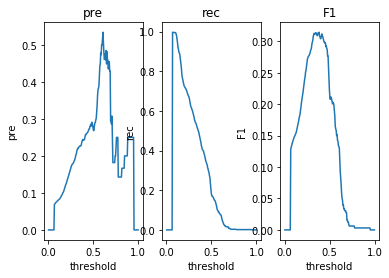

In [15]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(150, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(150, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 8s 792us/sample - loss: 0.1283 - mean_squared_error: 0.1283
Epoch 2/5
10000/10000 [==============================] - 7s 748us/sample - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 3/5
10000/10000 [==============================] - 8s 757us/sample - loss: 0.1278 - mean_squared_error: 0.1278
Epoch 4/5
10000/10000 [==============================] - 7s 721us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 5/5
10000/10000 [==============================] - 7s 731us/sample - loss: 0.1277 - mean_squared_error: 0.1277
corr:  [[1.         0.29028893]
 [0.29028893 1.        ]]
normal_err:  count    9368.000000
mean        0.192512
std         0.122358
min         0.000000
25%         0.112185
50%         0.162781
75%         0.236127
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.350162
std        0.164920
min        0.064832
25%        0.183162
50%        0.352352
75%        0.4

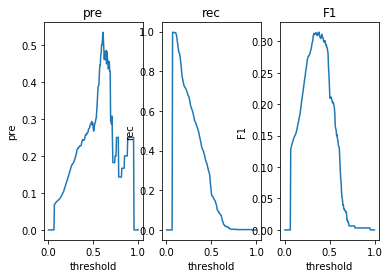

In [16]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 7s 685us/sample - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 2/5
10000/10000 [==============================] - 7s 654us/sample - loss: 0.0010 - mean_squared_error: 0.0010 - loss: 0.0011 - mean_squar - ETA: 1s - loss: 0.0011 - mean_s - ETA: 1s
Epoch 3/5
10000/10000 [==============================] - 7s 659us/sample - loss: 7.7544e-04 - mean_squared_error: 7.7544e-04
Epoch 4/5
10000/10000 [==============================] - 7s 664us/sample - loss: 6.5749e-04 - mean_squared_error: 6.5749e-04
Epoch 5/5
10000/10000 [==============================] - 7s 666us/sample - loss: 5.8816e-04 - mean_squared_error: 5.8816e-04
corr:  [[1.        0.1747782]
 [0.1747782 1.       ]]
normal_err:  count    9368.000000
mean        0.019098
std         0.029883
min         0.000000
25%         0.006801
50%         0.010827
75%         0.018128
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.044520
st

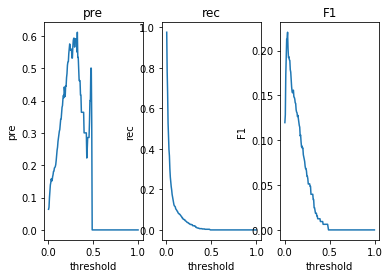

In [18]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 7s 728us/sample - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 2/5
10000/10000 [==============================] - 7s 690us/sample - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/5
10000/10000 [==============================] - 7s 676us/sample - loss: 0.0020 - mean_squared_error: 0.0020 - loss: 0.0
Epoch 4/5
10000/10000 [==============================] - 7s 672us/sample - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 5/5
10000/10000 [==============================] - 7s 688us/sample - loss: 0.0014 - mean_squared_error: 0.0014
corr:  [[1.         0.18088505]
 [0.18088505 1.        ]]
normal_err:  count    9368.000000
mean        0.162351
std         0.079521
min         0.000000
25%         0.115118
50%         0.155922
75%         0.195541
max         0.787865
dtype: float64
anomaly_err: count    632.000000
mean       0.228693
std        0.151722
min        0.015022
25%        0.149427
50%        0.178938
75

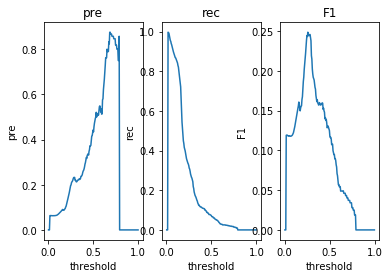

In [19]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 6s 600us/sample - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 2/5
10000/10000 [==============================] - 5s 548us/sample - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/5
10000/10000 [==============================] - 6s 554us/sample - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 4/5
10000/10000 [==============================] - 5s 543us/sample - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 5/5
10000/10000 [==============================] - 6s 561us/sample - loss: 0.0017 - mean_squared_error: 0.0017
corr:  [[1.         0.16500863]
 [0.16500863 1.        ]]
normal_err:  count    9368.000000
mean        0.159096
std         0.082090
min         0.000000
25%         0.111531
50%         0.145854
75%         0.191461
max         0.848830
dtype: float64
anomaly_err: count    632.000000
mean       0.221245
std        0.154260
min        0.014205
25%        0.115266
50%        0.160377
75%        0.2

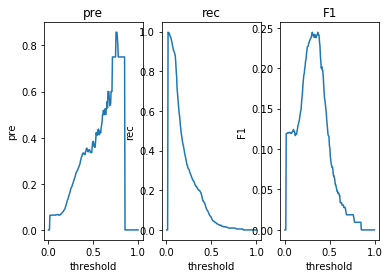

In [20]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(400, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
10000/10000 [==============================] - 5s 523us/sample - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 2/5
10000/10000 [==============================] - 5s 530us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - loss: 0.0015 - mean_squared_error
Epoch 3/5
10000/10000 [==============================] - 5s 516us/sample - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/5
10000/10000 [==============================] - 5s 512us/sample - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/5
10000/10000 [==============================] - 5s 516us/sample - loss: 0.0012 - mean_squared_error: 0.0012
corr:  [[1.         0.18233647]
 [0.18233647 1.        ]]
normal_err:  count    9368.000000
mean        0.169269
std         0.086323
min         0.000000
25%         0.115977
50%         0.157492
75%         0.198650
max         0.846638
dtype: float64
anomaly_err: count    632.000000
mean       0.241369
std        0.152356
min        0.021697
25%        0.143134
50%        0

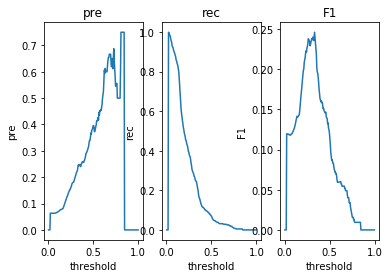

In [21]:
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
10000/10000 [==============================] - 5s 515us/sample - loss: 0.0012 - mean_squared_error: 0.0012 -
Epoch 2/5
10000/10000 [==============================] - 5s 530us/sample - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/5
10000/10000 [==============================] - 5s 521us/sample - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/5
10000/10000 [==============================] - 5s 514us/sample - loss: 9.5587e-04 - mean_squared_error: 9.5587e-04
Epoch 5/5
10000/10000 [==============================] - 5s 511us/sample - loss: 0.0010 - mean_squared_error: 0.0010
corr:  [[1.         0.16023431]
 [0.16023431 1.        ]]
normal_err:  count    9368.000000
mean        0.141329
std         0.071888
min         0.000000
25%         0.100460
50%         0.128306
75%         0.162550
max         0.945889
dtype: float64
anomaly_err: count    632.000000
mean       0.194893
std        0.141759
min        0.022033
25%        0.112690
50%        0.159376
75%        0.21554

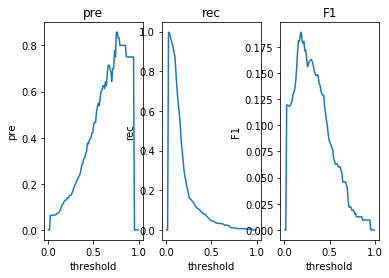

In [22]:
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
10000/10000 [==============================] - 15s 2ms/sample - loss: 0.0166 - mean_squared_error: 0.0166s - loss: - ETA
Epoch 2/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 5/5
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0028 - mean_squared_error: 0.0028
corr:  [[1.         0.06224329]
 [0.06224329 1.        ]]
normal_err:  count    9368.000000
mean        0.227272
std         0.107335
min         0.000000
25%         0.149720
50%         0.223757
75%         0.297042
max         0.867012
dtype: float64
anomaly_err: count    632.000000
mean       0.258084
std        0.160750
min        0.032885
25%        0.138761
50%        0.233067
75% 

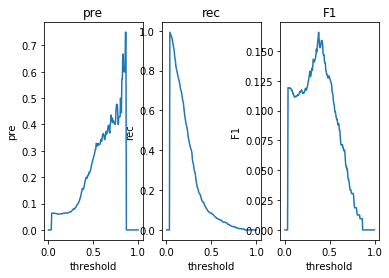

In [24]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    #tf.keras.layers.Dense(50, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(150, activation=tf.nn.relu),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 4/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 5/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0016 - mean_squared_error: 0.0016
corr:  [[1.         0.13007129]
 [0.13007129 1.        ]]
normal_err:  count    9368.000000
mean        0.143759
std         0.072902
min         0.000000
25%         0.090881
50%         0.132667
75%         0.186836
max         0.940418
dtype: float64
anomaly_err: count    632.000000
mean       0.186657
std        0.119355
min        0.020607
25%        0.098765
50%        0.158726
75%        0.243838
max        1.

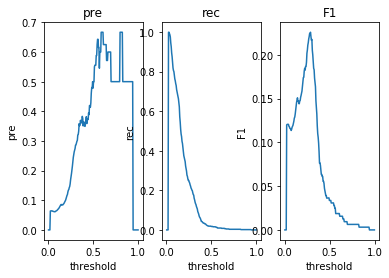

In [26]:
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.1045 - mean_squared_error: 0.1045
Epoch 2/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.1181 - mean_squared_error: 0.1181
Epoch 3/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.1084 - mean_squared_error: 0.1084
Epoch 4/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.1040 - mean_squared_error: 0.1040
Epoch 5/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.1084 - mean_squared_error: 0.1084
corr:  [[1.         0.22805843]
 [0.22805843 1.        ]]
normal_err:  count    9368.000000
mean        0.168546
std         0.121795
min         0.000000
25%         0.080188
50%         0.135241
75%         0.237449
max         0.829365
dtype: float64
anomaly_err: count    632.000000
mean       0.291177
std        0.187861
min        0.012090
25%        0.105371
50%        0.269129
75%        0.427910

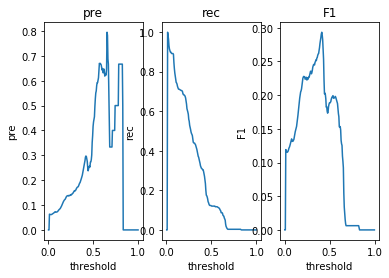

In [27]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(120, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(120, activation=tf.nn.relu),
    tf.keras.layers.Dense(120,activation=tf.nn.relu),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
30000/30000 [==============================] - 45s 1ms/sample - loss: 0.0976 - mean_squared_error: 0.0976
Epoch 2/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0813 - mean_squared_error: 0.0813s - loss: 0.0813 - mean_squ
Epoch 3/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0802 - mean_squared_error: 0.0802
Epoch 4/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0921 - mean_squared_error: 0.0921
Epoch 5/5
30000/30000 [==============================] - 45s 2ms/sample - loss: 0.0821 - mean_squared_error: 0.0821
corr:  [[1.         0.19839421]
 [0.19839421 1.        ]]
normal_err:  count    9368.000000
mean        0.232570
std         0.163834
min         0.000000
25%         0.098381
50%         0.194710
75%         0.343036
max         1.000000
dtype: float64
anomaly_er

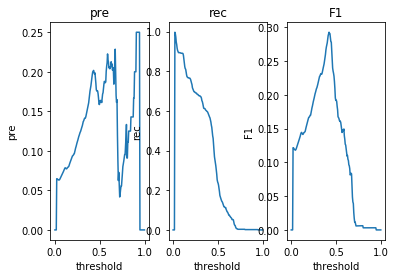

In [29]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(120, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(120, activation=tf.nn.relu),
    tf.keras.layers.Dense(200,activation=tf.nn.relu),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0940 - mean_squared_error: 0.0940
Epoch 2/5
30000/30000 [==============================] - 45s 1ms/sample - loss: 0.0749 - mean_squared_error: 0.0749
Epoch 3/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0836 - mean_squared_error: 0.0836
Epoch 4/5
30000/30000 [==============================] - 43s 1ms/sample - loss: 0.0912 - mean_squared_error: 0.0912
Epoch 5/5
30000/30000 [==============================] - 43s 1ms/sample - loss: 0.0889 - mean_squared_error: 0.0889
corr:  [[1.         0.18331487]
 [0.18331487 1.        ]]
normal_err:  count    9368.000000
mean        0.213011
std         0.141783
min         0.000000
25%         0.108126
50%         0.176123
75%         0.290033
max         0.953690
dtype: float64
anomaly_err: count    632.000000
mean       0.325039
std        0.190158
min        0.026452
25%        0.164499
50%        0.326119
75%        0.504181

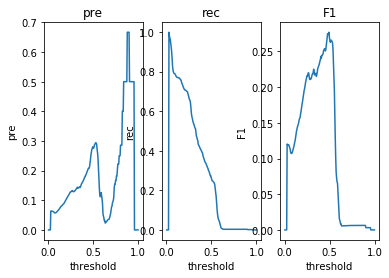

In [30]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(200,activation=tf.nn.relu),
    tf.keras.layers.Dense(450, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0899 - mean_squared_error: 0.0899
corr:  [[1.         0.16924928]
 [0.16924928 1.        ]]
normal_err:  count    9368.000000
mean        0.209932
std         0.153420
min         0.007733
25%         0.095024
50%         0.162999
75%         0.289652
max         0.961864
dtype: float64
anomaly_err: count    632.000000
mean       0.321869
std        0.202762
min        0.000000
25%        0.153026
50%        0.335714
75%        0.523245
max        1.000000
dtype: float64
Max F1:  , F1: 0.2651515151515151    , Recall:  0.27689873417721517    , pre:  0.2543604651162791  ,th:  0.5074999999999998


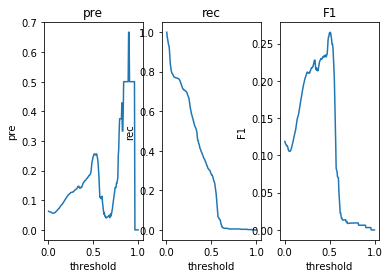

In [32]:
adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=1)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.005, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

30000/30000 [==============================] - 45s 1ms/sample - loss: 0.0916 - mean_squared_error: 0.0916
corr:  [[1.         0.17966074]
 [0.17966074 1.        ]]
normal_err:  count    9368.000000
mean        0.201636
std         0.148045
min         0.000000
25%         0.091891
50%         0.158072
75%         0.281260
max         0.963125
dtype: float64
anomaly_err: count    632.000000
mean       0.316493
std        0.197498
min        0.000767
25%        0.153577
50%        0.331259
75%        0.518010
max        1.000000
dtype: float64
Max F1:  , F1: 0.27910685805422647    , Recall:  0.27689873417721517    , pre:  0.28135048231511256  ,th:  0.49499999999999994


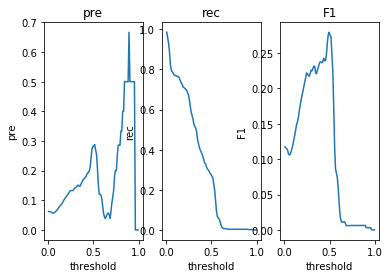

In [33]:
adam = tf.keras.optimizers.Adam(lr=0.0002, decay=1e-6)
model4.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=1)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

30000/30000 [==============================] - 31s 1ms/sample - loss: 0.0914 - mean_squared_error: 0.0914
corr:  [[1.         0.17686565]
 [0.17686565 1.        ]]
normal_err:  count    9368.000000
mean        0.203919
std         0.148418
min         0.002127
25%         0.094306
50%         0.159496
75%         0.283246
max         0.962678
dtype: float64
anomaly_err: count    632.000000
mean       0.317198
std        0.197520
min        0.000000
25%        0.155641
50%        0.329894
75%        0.518956
max        1.000000
dtype: float64
Max F1:  , F1: 0.2769472856018883    , Recall:  0.27848101265822783    , pre:  0.27543035993740217  ,th:  0.49499999999999994


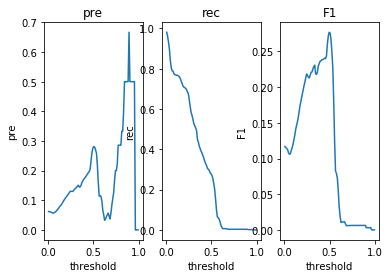

In [35]:
optim = tf.keras.optimizers.SGD(lr=0.0002, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=1)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

30000/30000 [==============================] - 46s 2ms/sample - loss: 0.0913 - mean_squared_error: 0.0913
corr:  [[1.         0.17117882]
 [0.17117882 1.        ]]
normal_err:  count    9368.000000
mean        0.204409
std         0.149459
min         0.000686
25%         0.092713
50%         0.160046
75%         0.287015
max         0.961286
dtype: float64
anomaly_err: count    632.000000
mean       0.314614
std        0.197364
min        0.000000
25%        0.152463
50%        0.326737
75%        0.515397
max        1.000000
dtype: float64
Max F1:  , F1: 0.27192276749798877    , Recall:  0.2674050632911392    , pre:  0.2765957446808511  ,th:  0.5049999999999999


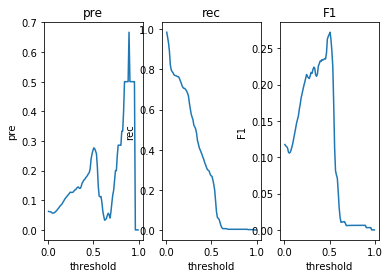

In [36]:
optim = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=1)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0883 - mean_squared_error: 0.0883
Epoch 2/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0596 - mean_squared_error: 0.0596
Epoch 3/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0476 - mean_squared_error: 0.0476
Epoch 4/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 5/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0335 - mean_squared_error: 0.0335
corr:  [[1.         0.18407782]
 [0.18407782 1.        ]]
normal_err:  count    9368.000000
mean        0.162956
std         0.102746
min         0.000000
25%         0.080173
50%         0.149581
75%         0.226409
max         0.972268
dtype: float64
anomaly_err: count    632.000000
mean       0.247437
std        0.165332
min        0.009164
25%        0.119760
50%        0.241525
75%        0.316813

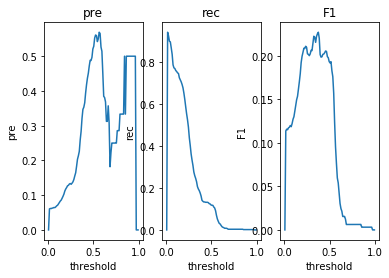

In [37]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(300, activation=tf.nn.relu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    #tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(300,activation=tf.nn.relu),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax),
    tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
optim = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 2/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0275 - mean_squared_error: 0.0275
Epoch 3/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0260 - mean_squared_error: 0.0260
Epoch 4/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 5/5
30000/30000 [==============================] - 36s 1ms/sample - loss: 0.0233 - mean_squared_error: 0.0233
corr:  [[1.        0.1642836]
 [0.1642836 1.       ]]
normal_err:  count    9368.000000
mean        0.142962
std         0.093964
min         0.000000
25%         0.072760
50%         0.125283
75%         0.198846
max         0.959187
dtype: float64
anomaly_err: count    632.000000
mean       0.211961
std        0.140645
min        0.004514
25%        0.111277
50%        0.191645
75%        0.312937
max        1.0000

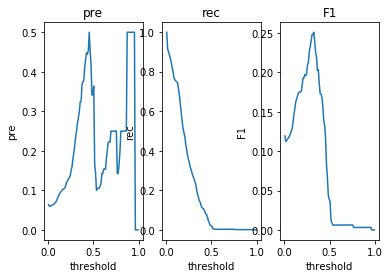

In [38]:
optim = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 2/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 3/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 4/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 5/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0218 - mean_squared_error: 0.0218
corr:  [[1.         0.15336439]
 [0.15336439 1.        ]]
normal_err:  count    9368.000000
mean        0.128186
std         0.096590
min         0.000000
25%         0.065221
50%         0.098171
75%         0.167781
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.193803
std        0.133330
min        0.017748
25%        0.094790
50%        0.166210
75%        0.286412
max        0.

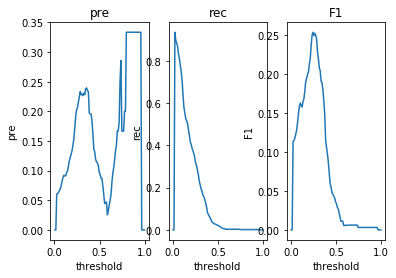

In [41]:
optim = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 2/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 3/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 4/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 5/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0212 - mean_squared_error: 0.0212
corr:  [[1.         0.13591095]
 [0.13591095 1.        ]]
normal_err:  count    9368.000000
mean        0.128840
std         0.105652
min         0.000000
25%         0.065388
50%         0.095367
75%         0.163476
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.191585
std        0.133754
min        0.018136
25%        0.092486
50%        0.159080
75%        0.286958
max        0.

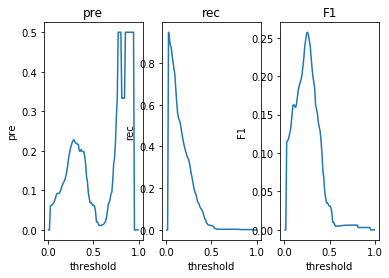

In [42]:
optim = tf.keras.optimizers.Adam(lr=0.0003, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 2/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 3/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 4/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 5/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0210 - mean_squared_error: 0.0210
corr:  [[1.         0.14267775]
 [0.14267775 1.        ]]
normal_err:  count    9368.000000
mean        0.124260
std         0.096529
min         0.000000
25%         0.065374
50%         0.094856
75%         0.158471
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.184716
std        0.123953
min        0.019859
25%        0.091481
50%        0.159015
75%        0.271829
max        0.

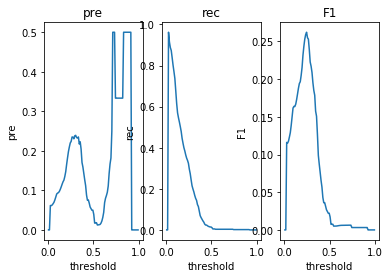

In [43]:
optim = tf.keras.optimizers.Adam(lr=0.0003, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 2/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 3/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 4/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0209 - mean_squared_error: 0.0209
Epoch 5/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0209 - mean_squared_error: 0.0209
corr:  [[1.         0.18101568]
 [0.18101568 1.        ]]
normal_err:  count    9368.000000
mean        0.122050
std         0.084432
min         0.000000
25%         0.066509
50%         0.095723
75%         0.161524
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.190626
std        0.126179
min        0.019327
25%        0.095789
50%        0.163373
75%        0.283048
max        0.

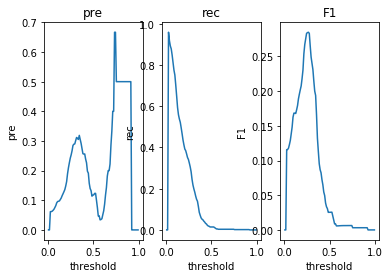

In [44]:
optim = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 2/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 3/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 4/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 5/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.0207 - mean_squared_error: 0.0207
corr:  [[1.         0.13493134]
 [0.13493134 1.        ]]
normal_err:  count    9368.000000
mean        0.126790
std         0.102024
min         0.000000
25%         0.065176
50%         0.094330
75%         0.161239
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.186906
std        0.124362
min        0.017061
25%        0.094045
50%        0.163840
75%        0.280356
max        0.

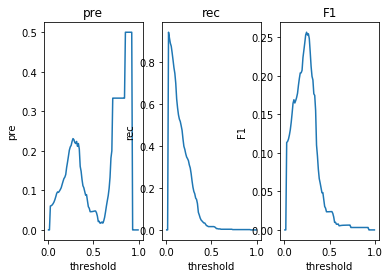

In [45]:
optim = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-6)
model4.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model4.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model4, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 2/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 3/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 4/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 5/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
corr:  [[1.         0.14365194]
 [0.14365194 1.        ]]
normal_err:  count    9368.000000
mean        0.127860
std         0.099802
min         0.000000
25%         0.065802
50%         0.096264
75%         0.165244
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.190862
std        0.127871
min        0.015682
25%        0.095989
50%        0.165086
75%        0.286122
max        0.

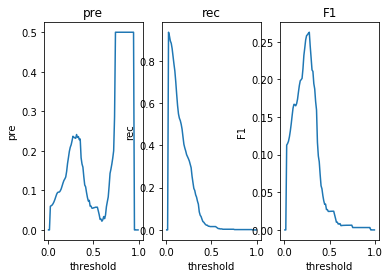

In [48]:
optim = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-6)
model5 = tf.keras.models.clone_model(model4)
model5.set_weights(model4.get_weights())
model5.compile(optimizer=optim,
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model5.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model5, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

Epoch 1/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 2/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 4/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
Epoch 5/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0206 - mean_squared_error: 0.0206
corr:  [[1.         0.14473543]
 [0.14473543 1.        ]]
normal_err:  count    9368.000000
mean        0.125035
std         0.096342
min         0.000000
25%         0.064946
50%         0.094887
75%         0.159813
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.186495
std        0.125122
min        0.018105
25%        0.091246
50%        0.161525
75%        0.277907
max        0.

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2768817204301075    , Recall:  0.3259493670886076    , pre:  0.24065420560747663  ,th:  0.26499999999999996
Epoch 1/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 2/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 4/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 5/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
corr:  [[1.         0.16812876]
 [0.16812876 1.        ]]
normal_err:  count    9368.000000
mean        0.128279
std         0.093842
min         0.000000
25%         0.068441
50%         0.099118
75%         0.167354
max         0.987663
dtype: float64
anomaly_err: count    632.000000
mean    

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2774647887323944    , Recall:  0.31170886075949367    , pre:  0.25  ,th:  0.27499999999999997
Epoch 1/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 2/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 4/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204s - loss: 0.0204 - mean_s
Epoch 5/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0205 - mean_squared_error: 0.0205
corr:  [[1.       0.156887]
 [0.156887 1.      ]]
normal_err:  count    9368.000000
mean        0.130653
std         0.098892
min         0.000000
25%         0.068718
50%         0.101236
75%         0.167465
max         0.972412
dtype: float64
anomaly_err: count    632.000000
mean 

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2681491170699804    , Recall:  0.32436708860759494    , pre:  0.22853957636566333  ,th:  0.26499999999999996
Epoch 1/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204s
Epoch 3/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204 24s -
Epoch 4/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 5/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
corr:  [[1.         0.14288397]
 [0.14288397 1.        ]]
normal_err:  count    9368.000000
mean        0.131589
std         0.102680
min         0.000000
25%         0.068612
50%         0.100320
75%         0.166175
max         0.955423
dtype: float64
anomaly_err: count    632.000000


d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2567901234567901    , Recall:  0.3291139240506329    , pre:  0.21052631578947367  ,th:  0.25499999999999995
Epoch 1/5
30000/30000 [==============================] - 43s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 4/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204s - loss: 0.0204 - 
Epoch 5/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
corr:  [[1.         0.16568083]
 [0.16568083 1.        ]]
normal_err:  count    9368.000000
mean        0.124055
std         0.090315
min         0.000000
25%         0.066304
50%         0.097118
75%         0.161945
max         0.951800
dtype: float64
anomaly_err: count    

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2697674418604651    , Recall:  0.3212025316455696    , pre:  0.2325315005727377  ,th:  0.25499999999999995
Epoch 1/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 2/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 3/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 4/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 5/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
corr:  [[1.         0.16288883]
 [0.16288883 1.        ]]
normal_err:  count    9368.000000
mean        0.124904
std         0.091044
min         0.000000
25%         0.066882
50%         0.097777
75%         0.162105
max         0.929758
dtype: float64
anomaly_err: count    632.000000
mean     

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.26930693069306927    , Recall:  0.3227848101265823    , pre:  0.23103057757644394  ,th:  0.25499999999999995
Epoch 1/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 2/5
30000/30000 [==============================] - 41s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 3/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 4/5
30000/30000 [==============================] - 40s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 5/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
corr:  [[1.         0.17424329]
 [0.17424329 1.        ]]
normal_err:  count    9368.000000
mean        0.124242
std         0.087622
min         0.000000
25%         0.067566
50%         0.098257
75%         0.161849
max         0.981145
dtype: float64
anomaly_err: count    632.000000
mean   

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.27464788732394363    , Recall:  0.30854430379746833    , pre:  0.24746192893401014  ,th:  0.26499999999999996
Epoch 1/5
30000/30000 [==============================] - 44s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 2/5
30000/30000 [==============================] - 45s 2ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 3/5
30000/30000 [==============================] - 45s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 4/5
30000/30000 [==============================] - 43s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 5/5
30000/30000 [==============================] - 43s 1ms/sample - loss: 0.0203 - mean_squared_error: 0.0203
corr:  [[1.         0.16741744]
 [0.16741744 1.        ]]
normal_err:  count    9368.000000
mean        0.124569
std         0.089839
min         0.000000
25%         0.067484
50%         0.097655
75%         0.162049
max         0.976978
dtype: float64
anomaly_err: count    632.000000
mean  

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.2717031146454606    , Recall:  0.32436708860759494    , pre:  0.233751425313569  ,th:  0.25499999999999995
Epoch 1/5
 3168/30000 [==>...........................] - ETA: 54s - loss: 0.0205 - mean_squared_error: 0.0205

KeyboardInterrupt: 

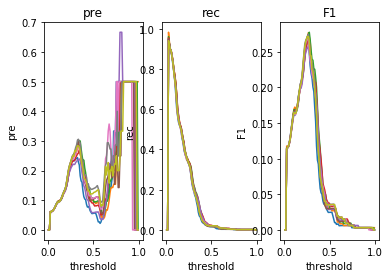

In [50]:
models = []
models.append(model5)
for i in range(10):
    old_model=models[i]
    optim = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-6)
    new_model = tf.keras.models.clone_model(old_model)
    new_model.set_weights(old_model.get_weights())
    new_model.compile(optimizer=optim,
                  loss=tf.keras.losses.mean_squared_error,
                   metrics=["mse"])
    new_model.fit(train_x, train_y, epochs=5)
    res = eval_model(get_pred_errors(new_model, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
    index = np.argmax(res["F1"])
    print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])
    models.append(new_model)

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.1274 - mean_squared_error: 0.1274
Epoch 2/5
30000/30000 [==============================] - 37s 1ms/sample - loss: 0.1271 - mean_squared_error: 0.1271
Epoch 3/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.1271 - mean_squared_error: 0.1271
Epoch 4/5
30000/30000 [==============================] - 38s 1ms/sample - loss: 0.1271 - mean_squared_error: 0.1271
Epoch 5/5
30000/30000 [==============================] - 26s 864us/sample - loss: 0.1271 - mean_squared_error: 0.1271
corr:  [[1.         0.29027044]
 [0.29027044 1.        ]]
normal_err:  count    9368.000000
mean        0.192011
std         0.122635
min         0.000000
25%         0.111070
50%         0.162512
75%         0.235872
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.349952
std        0.164707
min        0.064820
25%        0.183311
50%        0.352501
75%        0.4844

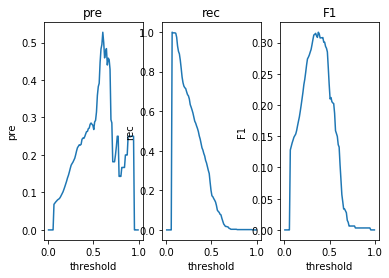

In [51]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model1.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model1.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model1, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 55s 2ms/sample - loss: 0.1278 - mean_squared_error: 0.1278
Epoch 2/5
30000/30000 [==============================] - 50s 2ms/sample - loss: 0.1273 - mean_squared_error: 0.1273
Epoch 3/5
30000/30000 [==============================] - 39s 1ms/sample - loss: 0.1272 - mean_squared_error: 0.1272
Epoch 4/5
30000/30000 [==============================] - 55s 2ms/sample - loss: 0.1272 - mean_squared_error: 0.1272
Epoch 5/5
30000/30000 [==============================] - 52s 2ms/sample - loss: 0.1272 - mean_squared_error: 0.1272
corr:  [[1.        0.2904526]
 [0.2904526 1.       ]]
normal_err:  count    9368.000000
mean        0.192620
std         0.122349
min         0.000000
25%         0.111889
50%         0.163229
75%         0.236731
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.350337
std        0.164563
min        0.065424
25%        0.183941
50%        0.352541
75%        0.484436
max

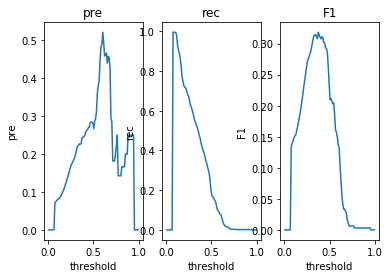

In [52]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model2.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model2.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model2, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
Epoch 1/5
30000/30000 [==============================] - 57s 2ms/sample - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 2/5
30000/30000 [==============================] - 42s 1ms/sample - loss: 0.1275 - mean_squared_error: 0.1275
Epoch 3/5
30000/30000 [==============================] - 55s 2ms/sample - loss: 0.1275 - mean_squared_error: 0.1275
Epoch 4/5
30000/30000 [==============================] - 60s 2ms/sample - loss: 0.1274 - mean_squared_error: 0.1274
Epoch 5/5
30000/30000 [==============================] - 60s 2ms/sample - loss: 0.1277 - mean_squared_error: 0.1277
corr:  [[1.         0.28861309]
 [0.28861309 1.        ]]
normal_err:  count    9368.000000
mean        0.193349
std         0.122968
min         0.000000
25%         0.112788
50%         0.163393
75%         0.236408
max         1.000000
dtype: float64
anomaly_err: count    632.000000
mean       0.350715
std        0.164946
min        0.064841
25%        0.183797
50%        0.353417
75%        0.486440

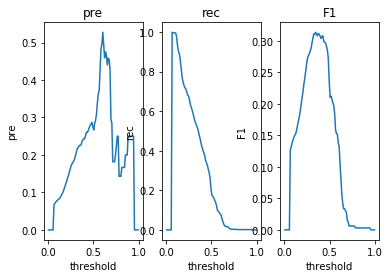

In [53]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)

model3 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model3.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
model3.fit(train_x, train_y, epochs=5)
res = eval_model(get_pred_errors(model3, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
corr:  [[1.         0.30066123]
 [0.30066123 1.        ]]
normal_err:  count    28317.000000
mean         0.181864
std          0.117454
min          0.000000
25%          0.104169
50%          0.155163
75%          0.222720
max          1.000000
dtype: float64
anomaly_err: count    1683.000000
mean        0.347487
std         0.174145
min         0.066058
25%         0.172648
50%         0.365039
75%         0.482380
max         0.967801
dtype: float64
Max F1:  , F1: 0.34627901931004557    , Recall:  0.4741532976827095    , pre:  0.2727272727272727  ,th:  0.37499999999999994
Epoch 1/5
50000/50000 [==============================] - 14s 280us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 2/5
50000/50000 [==============================] - 14s 270us/sample - loss: 0.1273 - mean_squared_error: 0.1273
Epoch 3/5
50000/50000 [==============================] - 14s 276us/sample - loss: 0.1274 - mean_squared_error: 0.1274
Epoch 4/5
50000/50000 [==========================

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.347069786705322    , Recall:  0.4979203802733215    , pre:  0.2663699936427209  ,th:  0.36499999999999994


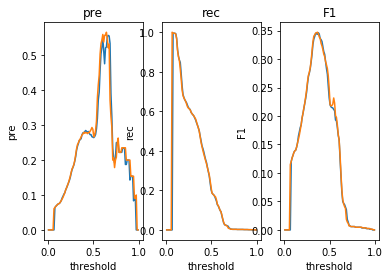

In [12]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)
# train_size = 50000, test_size = 30000

model6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model6.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

model6.fit(train_x, train_y, epochs=5)

res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
train_size:  100000 test_size 50000
corr:  [[1.         0.30070224]
 [0.30070224 1.        ]]
normal_err:  count    47197.000000
mean         0.181752
std          0.117538
min          0.000000
25%          0.104075
50%          0.155023
75%          0.222645
max          1.000000
dtype: float64
anomaly_err: count    2803.000000
mean        0.347045
std         0.173831
min         0.065548
25%         0.172470
50%         0.364337
75%         0.482474
max         0.958502
dtype: float64
Max F1:  , F1: 0.34623908225785427    , Recall:  0.47377809489832323    , pre:  0.27280197206244866  ,th:  0.37499999999999994
Epoch 1/5
100000/100000 [==============================] - 28s 281us/sample - loss: 0.1281 - mean_squared_error: 0.1281
Epoch 2/5
100000/100000 [==============================] - 28s 278us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/5
100000/100000 [==============================] - 28s 276us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.34651513394410294    , Recall:  0.5330003567606136    , pre:  0.256701030927835  ,th:  0.345


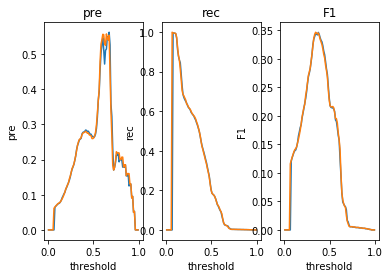

In [14]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)
print("train_size: ", len(train_x), "test_size", len(test_x))

model6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model6.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

model6.fit(train_x, train_y, epochs=5)

res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
train_size:  118798 test_size 172772
corr:  [[1.         0.29058911]
 [0.29058911 1.        ]]
normal_err:  count    162048.000000
mean          0.193436
std           0.121865
min           0.000000
25%           0.114338
50%           0.163176
75%           0.238032
max           1.000000
dtype: float64
anomaly_err: count    10724.000000
mean         0.351083
std          0.163051
min          0.065355
25%          0.185004
50%          0.354123
75%          0.484803
max          0.967687
dtype: float64
Max F1:  , F1: 0.3140425531914894    , Recall:  0.5161320402834764    , pre:  0.2256788714017777  ,th:  0.345
Epoch 1/5
118798/118798 [==============================] - 37s 308us/sample - loss: 0.1279 - mean_squared_error: 0.1279
Epoch 2/5
118798/118798 [==============================] - 35s 298us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/5
118798/118798 [==============================] - 37s 315us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.3145225825037611    , Recall:  0.4581312942931742    , pre:  0.23945996003314324  ,th:  0.37499999999999994


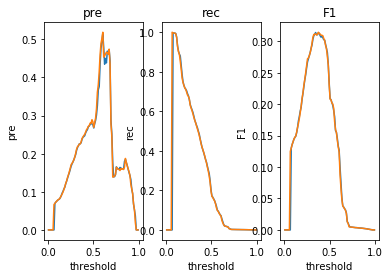

In [17]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)
print("train_size: ", len(train_x), "test_size", len(test_x))

model6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model6.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

model6.fit(train_x, train_y, epochs=5)

res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

data_dim: 900
train_size:  118798 test_size 172772
corr:  [[1.         0.13157066]
 [0.13157066 1.        ]]
normal_err:  count    5222.000000
mean        0.106355
std         0.055233
min         0.031520
25%         0.061396
50%         0.116479
75%         0.140025
max         0.429133
dtype: float64
anomaly_err: count    167550.000000
mean          0.206268
std           0.131030
min           0.000000
25%           0.119152
50%           0.169467
75%           0.255643
max           1.000000
dtype: float64
Max F1:  , F1: 0.9843423462084493    , Recall:  0.9993733213965981    , pre:  0.9697568151412835  ,th:  0.005
Epoch 1/5
118798/118798 [==============================] - 33s 275us/sample - loss: 0.1278 - mean_squared_error: 0.1278- loss: 0.1279 - mean_squar
Epoch 2/5
118798/118798 [==============================] - 35s 296us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/5
118798/118798 [==============================] - 33s 276us/sample - loss: 0.1276 - mean_squared_

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.9843304047758316    , Recall:  0.9993494479259922    , pre:  0.9697561145120842  ,th:  0.005


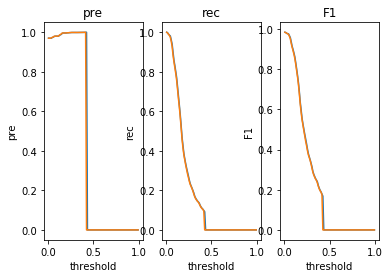

In [22]:
data_dim = sample_size * dimension
print("data_dim:", data_dim)
print("train_size: ", len(train_x), "test_size", len(test_x))

model6 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    #tf.keras.layers.Dense(450, activation=tf.nn.relu),
   # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(0, activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80,activation=tf.nn.relu),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
  #  tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax)
    #tf.keras.layers.Dense(sample_size*dimension, activation=None)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model6.compile(optimizer="Adam",
              loss=tf.keras.losses.mean_squared_error,
               metrics=["mse"])
res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

model6.fit(train_x, train_y, epochs=5)

res = eval_model(get_pred_errors(model6, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
index = np.argmax(res["F1"])
print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])

In [ ]:
models6 = []
models6.append(model6)
for i in range(10):
    old_model=models6[i]
    optim = tf.keras.optimizers.Adam(lr=0.0004, decay=1e-6)
    new_model = tf.keras.models.clone_model(old_model)
    new_model.set_weights(old_model.get_weights())
    new_model.compile(optimizer=optim,
                  loss=tf.keras.losses.mean_squared_error,
                   metrics=["mse"])
    new_model.fit(train_x, train_y, epochs=5)
    res = eval_model(get_pred_errors(new_model, test_x, test_y), test_attack_level, th_int=0.01, attack_th=0.02)
    index = np.argmax(res["F1"])
    print("Max F1: ", ", F1:", res["F1"][index], "   , Recall: ", res["rec"][index], "   , pre: ", res["pre"][index], " ,th: ", res["th"][index])
    models6.append(new_model)

Epoch 1/5
118798/118798 [==============================] - 36s 302us/sample - loss: 0.1278 - mean_squared_error: 0.1278
Epoch 2/5
118798/118798 [==============================] - 38s 322us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/5
118798/118798 [==============================] - 37s 314us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 4/5
118798/118798 [==============================] - 37s 313us/sample - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 5/5
118798/118798 [==============================] - 37s 310us/sample - loss: 0.1276 - mean_squared_error: 0.1276
corr:  [[1.         0.28941488]
 [0.28941488 1.        ]]
normal_err:  count    162048.000000
mean          0.192733
std           0.121258
min           0.000000
25%           0.113804
50%           0.163389
75%           0.235938
max           1.000000
dtype: float64
anomaly_err: count    10724.000000
mean         0.349042
std          0.163580
min          0.063442
25%          0.183471
50%    

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.3117951060731519    , Recall:  0.5091383812010444    , pre:  0.2247006049631672  ,th:  0.345
Epoch 1/5
118798/118798 [==============================] - 42s 353us/sample - loss: 0.1276 - mean_squared_error: 0.1276
Epoch 2/5
118798/118798 [==============================] - 43s 359us/sample - loss: 0.1276 - mean_squared_error: 0.1276
Epoch 3/5
118798/118798 [==============================] - 43s 358us/sample - loss: 0.1276 - mean_squared_error: 0.1276
Epoch 4/5
118798/118798 [==============================] - 41s 349us/sample - loss: 0.1276 - mean_squared_error: 0.1276
Epoch 5/5
118798/118798 [==============================] - 41s 348us/sample - loss: 0.1276 - mean_squared_error: 0.1276
corr:  [[1.         0.28910497]
 [0.28910497 1.        ]]
normal_err:  count    162048.000000
mean          0.192684
std           0.121208
min           0.000000
25%           0.113766
50%           0.163406
75%           0.235598
max           1.000000
dtype: float64
anomaly_err: count  

d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
d:\install\anaconda3\envs\anomaly\lib\site-packages\ipykernel_launcher.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

Max F1:  , F1: 0.311897380471572    , Recall:  0.5112831033196569    , pre:  0.22439124207080008  ,th:  0.345
Epoch 1/5
 25120/118798 [=====>........................] - ETA: 40s - loss: 0.1276 - mean_squared_error: 0.1276

In [ ]:
#anomaly_data_2 = anomaly_data.copy()
delay_time = 300
for i in range(len(anomaly_pc)-delay_time):
    if(anomaly_data_2[i][-1]>0.9 and anomaly_data_2[i+1][-1]<0.1):
        for j in range(delay_time):
               anomaly_data_2[i+1+j][-1]=1

normal_len = len(normal_pc)
anomaly_len = len(anomaly_pc)
dimension = normal_pc.shape[1]
sample_size = 30
train_size = (normal_len-sample_size)//10+1
sample_step = np.floor((normal_len-sample_size)/(train_size-1)).astype(int)
print("sample_step: ", sample_step)
train_x = np.zeros((train_size, sample_size, dimension), dtype="double")
for i in range(train_size):
    train_x[i, :, :] = normal_pc\
    [i*sample_step: (i*sample_step+sample_size), :]
train_y = np.zeros((train_size, sample_size*dimension), dtype = "double")
for i in range(train_size):
    train_y[i] = train_x[i,:,:].ravel()
test_size = (anomaly_len-sample_size)//1+1
test_sample_step=np.floor((anomaly_len-sample_size)/(test_size-1)).astype(int)
print("test_sample_step: ", test_sample_step)
test_index = np.array([i*test_sample_step for i in range(test_size)])
test_normal_index = np.array([i for i in test_index \
                              if np.mean(anomaly_pc[i:(i+sample_size), -1])<0.2])
print("normal size:", len(test_normal_index))
left_index_index = np.array(range(0,len(test_normal_index),1))
print("left size: ", len(left_index_index))

test_normal_index_left = test_normal_index[left_index_index]
test_index_final = np.array([i for i in test_index \
                             if (i not in test_normal_index) or (i in test_normal_index_left)])
print("final: ", len(test_index_final))
new_test_size = len(test_index_final)
print(new_test_size)
test_x = np.zeros((new_test_size, sample_size, dimension), dtype = "double")
for i in range(new_test_size):
    test_x[i,:,:] = anomaly_pc[test_index_final[i]:(test_index_final[i]+sample_size), :-1]
test_y = np.zeros((new_test_size, sample_size*dimension), dtype = "double")
for i in range(new_test_size):
    test_y[i] = test_x[i,:,:].ravel()
test_attack_level = np.array([np.mean(anomaly_pc\
                                      [i:(i+sample_size), -1]) for i in test_index_final])
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    if(TP==0 or FP==0 or FN==0):
        #print("someone=0, TP=", TP, " FP=", FP, ", FN=",FN)
        return (0,0,0)
    pre = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    
def get_pred_errors(model, test_x, test_y):
    test_pred = model.predict(test_x)
    return np.array([mean_squared_error(test_y[i], test_pred[i]) for i in range(len(test_y))])
def eval_model(errors, attack_levels, th_int=0.1, attack_th=0.3):
    err_normalized = normalize_1d(errors)
    thresholds = np.arange(0.5*th_int,1,th_int)
    print("corr: ", np.corrcoef(err_normalized, attack_levels))
    attack_th = np.array([1 if i>attack_th else 0 for i in attack_levels])
    
    normal_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==0])
    anomaly_err = np.array([err_normalized[i] for i in range(len(err_normalized)) if attack_th[i]==1])
    print("normal_err: ", pd.Series(normal_err).describe())
    print("anomaly_err:", pd.Series(anomaly_err).describe())
    
    
    res = {"th":np.zeros((len(thresholds))),"pre":np.zeros((len(thresholds))), "rec":np.zeros((len(thresholds))), "F1":np.zeros((len(thresholds)))}
    for i in range(len(thresholds)):
        th = thresholds[i]
        #print("Threshold = ", th)
        err_thd = np.array([1 if i >th else 0 for i in err_normalized])
        pre, rec, F1=get_eval(attack_th, err_thd)
        res["th"][i]=th
        res["pre"][i]=pre
        res["rec"][i] = rec
        res["F1"][i] = F1
    plt.subplot(1,3,1)
    plt.plot(thresholds, res["pre"])
    plt.xlabel("threshold")
    plt.ylabel("pre")
    plt.title("pre")
    
    plt.subplot(1,3,2)
    plt.plot(thresholds, res["rec"])
    plt.xlabel("threshold")
    plt.ylabel("rec")
    plt.title("rec")
    
    plt.subplot(1,3,3)
    plt.plot(thresholds, res["F1"])
    plt.xlabel("threshold")
    plt.ylabel("F1")
    plt.title("F1")
    return res